This notebook gives an overview of EDMCMC, or Easy Differential Evolution Markov Chain Monte Carlo (MCMC), a routine for parameter inference using the differential evolution MCMC alvorithm of ter Braak (2006), available at http://dx.doi.org/10.1007/s11222-006-8769-1. It includes basic usage examples and demonstrations of different features. 

First, let's create a fake dataset to fit as a demonstration: 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import edmcmc as edm
import corner
import time

In [17]:
x = np.linspace(0, 10, 30)# generate an evenly sampled X axis (not strictly necessary for this problem). 
slope_true = 1.5
intercept_true = 4
uncertainty_true = 1 # These parameters are the "truth" that our MCMC will try to recover. 

In [18]:
y = slope_true * x + intercept_true #Calculate the y values based on the linear model
y = y + np.random.normal(0, uncertainty_true, len(x)) #and add some random noise with
#a Gaussian distribution centered on 0, with a standard deviation of 1. 
err = np.ones_like(y) * uncertainty_true

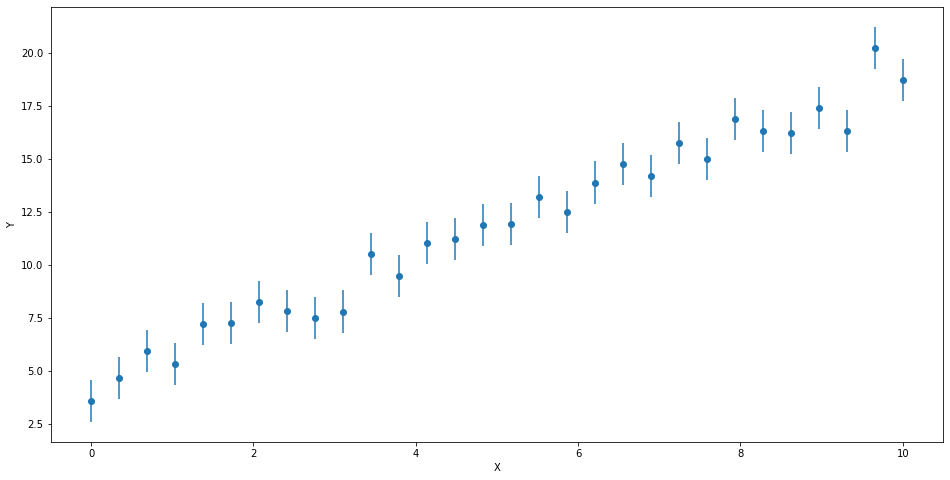

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(x, y, yerr = np.ones_like(y) * uncertainty_true, fmt = 'o')
ax.set_ylabel('Y');
ax.set_xlabel('X');


Now that we have a dataset, we can define a likelihood function. This function evaluates the . By default, EDMCMC works with functions that return the natural logarithm (base e) of the likelihood, but also can work with functions that return χ^2 (chi squared) values or the negative value of the log likelihood, if a keyword is passed. 

In this case, the likelihood function calculates a model based on an array of parameters (p) and compares it to the data (x, y, e) using a simple calculation of χ^2, which it then converts into log likelihood. 

In [20]:
def loglikelihood(p, x, y, e): #here p is an array of the parameters: let's define p[0] = slope, and p[1] = intercept 
    slope = p[0]
    intercept = p[1]
    model = slope * x + intercept
    chisq = np.sum((y - model)**2 / e**2) 
    loglikelihood = -0.5 * chisq
    return loglikelihood

Running EDMCMC involves a single function call. The key input parameters are the likelihood function, starting values for each parameter (an array with length equal to the number of parameters accepted by the likelihood function), an array of widths for the initial starting distribution of each parameter (should be roughly the expected final parameter uncertainty), a tuple of arguments to be passed to the likelihood function (in this case, we pass the x and y arrays, and the array of individual uncertainties), and information about how long to run the MCMC. The key parameters are nlink (the number of steps for each chain to run), nwalkers (the number of chains), and nburnin (the number of steps at the beginning of the MCMC before the chains reached equilibrium to automatically remove). 

By default, EDMCMC prints a line at each step updating the progress, estimating the time until the MCMC completes, and reporting the acceptance rate (a metric of how well efficiently the MCMC is exploring paramter space). The optimal value of the acceptance rate is about 0.23, but it is usually nothing to worry about unless the acceptance rate comes particulary close to 100% or 0%. 

In [21]:
out = edm.edmcmc(loglikelihood, [0,0], [.1,.1],
             args=(x,y,err), nwalkers=200, nlink = 1000, nburnin=500)
print(np.median(out.flatchains[:,0]), '+/-', np.std(out.flatchains[:,0]), ';    ', np.median(out.flatchains[:,1]), '+/-', np.std(out.flatchains[:,1]))


0 days, 00:00:00.0 remains. Link 1000 of 1000. Acceptance Rate= 0.35
1.4654877255056238 +/- 0.06147075674276358 ;     4.431733510217587 +/- 0.35611083423677115


EDMCMC returns an object containing the positions of each walker at each link (the Markov chains) and other handy diagnostic information like the negative logarithm of the likelihood of each model evaluation. The chains (with burn-in removed) can be accessed and plotted with the following commands: 

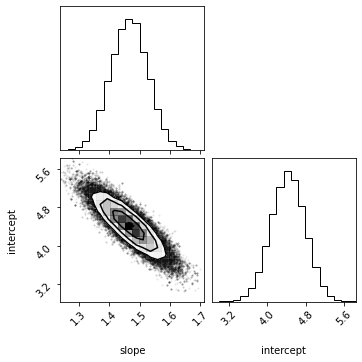

In [22]:
corner.corner(out.flatchains,labels=['slope', 'intercept'])
plt.show()

Here are a few other examples of how to use the output: 

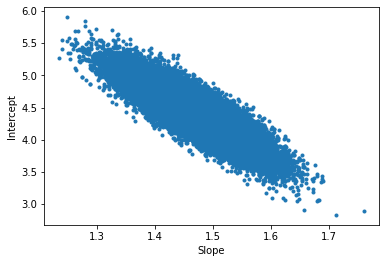

In [23]:
thinflatchains = out.get_chains(nthin =5, nburnin = 200, flat=True)# you can specify different amounts of 
                                    #burnin and thin the chains to save 
                                    #memory using the get_chains function
        
a=plt.plot(thinflatchains[:,0], thinflatchains[:,1],'.')
a=plt.xlabel('Slope')
a=plt.ylabel('Intercept')

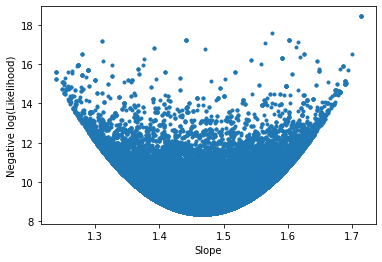

In [24]:
a=plt.plot(out.flatchains[:,0], out.flatneglogl, '.') #You can get the log likelihood values 
                                                    #for each position in the chains
a=plt.xlabel('Slope')
a=plt.ylabel('Negative log(Likelihood)')

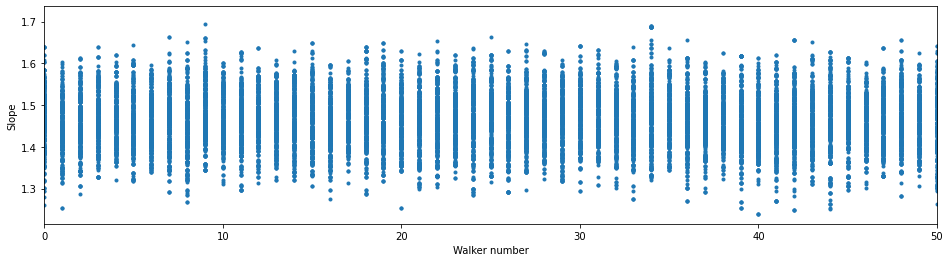

In [25]:
fig, ax = plt.subplots(figsize=(16, 4))
a=plt.plot(out.whichwalker, out.flatchains[:,0], '.')   #You can find which positions came from which walker 
                                                        #and identify any walkers that got stuck in a different local
                                                        #likelihood maximum
a=plt.xlabel('Walker number')
a=plt.ylabel('Slope')
a=plt.xlim(0,50)

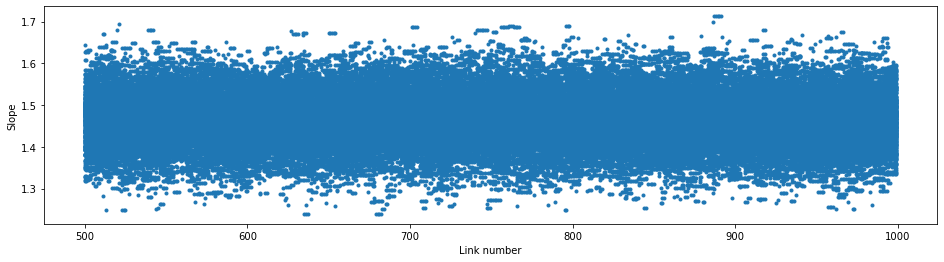

In [26]:
fig, ax = plt.subplots(figsize=(16, 4))
a=plt.plot(out.whichlink, out.flatchains[:,0], '.')   #You can plot the position of the walkers as a function of link 
                                                        #number and see if the walkers are behaving in equilibrium or
                                                        #are still converging to the true solution
a=plt.xlabel('Link number')
a=plt.ylabel('Slope')


EDMCMC supports hard limits on parameters natively (these limits and other priors can of course be incorporated into likelihood functions as well). To incorporate these limits, send in a dictionary called parinfo with the following information: 

0 days, 00:00:00.5 remains. Link 539 of 1000. Acceptance Rate= 0.3

0 days, 00:00:00.0 remains. Link 1000 of 1000. Acceptance Rate= 0.3


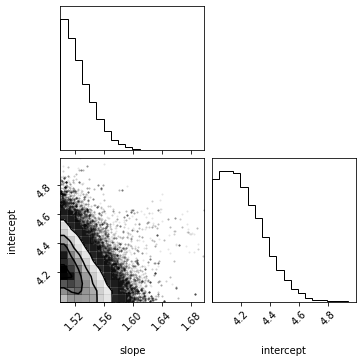

In [27]:
parinfo = [{'fixed': False, 'limits': [1.5,1.7], 'limited': [True,True]}, #limit parameter 0 to be between 1.5 and 1.7
           {'fixed': False, 'limits': [4,5], 'limited': [True,True]}] #and parameter 2 to be between 4 and 5
out = edm.edmcmc(loglikelihood, [1.5,4.5], [.1,.1], parinfo=parinfo, args=(x,y,err), 
             nwalkers=200, nlink = 1000, ncores=1, nburnin=0)

corner.corner(out.flatchains,labels=['slope', 'intercept'])
plt.show()

In cases like these, it is important to put your starting parameters within the acceptable ranges; otherwise EDMCMC may fail to find good initial walker positions. 

YOu can also use the parinfo dictionary to "freeze" parameters at certain values. Below, we turn off the hard limits on the parameter values by setting th e

0 days, 00:00:00.0 remains. Link 1000 of 1000. Acceptance Rate= 0.44


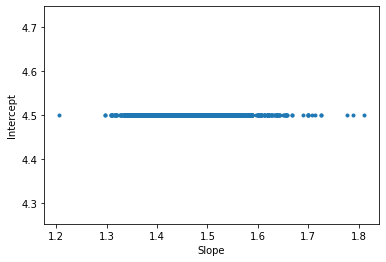

In [28]:
parinfo = [{'fixed': False, 'limits': [1.5,1.7], 'limited': [False,False]}, #Unlimited since both elements of 
           {'fixed': True, 'limits': [4,5], 'limited': [False,False]}] #"limited" are False . But parameter 1 is
                                                                        #fixed at its starting value of 4.5
out = edm.edmcmc(loglikelihood, [1.5,4.5], [.1,.1], parinfo=parinfo, args=(x,y,err), 
             nwalkers=200, nlink = 1000, ncores=1, nburnin=0)

plt.plot(out.flatchains[:,0], out.flatchains[:,1], '.');
a=plt.xlabel('Slope')
a=plt.ylabel('Intercept')

EDMCMC supports parallelization of the likelihood function calculation. This can significantly speed up the MCMC, especially when the likelihood function is computationally expensive. To demonstrate, let's define a more computationally expensive likelihood function and test with and without parallelization. The results here are for a laptop computer with a two-core processor running four threads. 

In [29]:
def expensiveloglikelihood(p, x, y, e): #here p is an array of the parameters: let's define p[0] = slope, and p[1] = intercept 
    
    j = np.zeros(20000) + 2#this doesn't do anything but make the likelihood function more expensive 
    j = j**j #to test parallelization
    
    slope = p[0]
    intercept = p[1]
    model = slope * x + intercept
    chisq = np.sum((y - model)**2 / e**2) 
    loglikelihood = -0.5 * chisq
    return loglikelihood

In [ ]:
starttime = time.time()
out = edm.edmcmc(expensiveloglikelihood, [0,0], [.1,.1],
             args=(x,y,err), nwalkers=200, nlink = 1000, nburnin=500)
print(np.median(out.flatchains[:,0]), '+/-', np.std(out.flatchains[:,0]), ';    ',
      np.median(out.flatchains[:,1]), '+/-', np.std(out.flatchains[:,1]))
print('One thread: ', time.time()-starttime, ' seconds')

starttime = time.time()
out = edm.edmcmc(expensiveloglikelihood, [0,0], [.1,.1],
             args=(x,y,err), nwalkers=200, nlink = 1000, nburnin=500, ncores=2)
print(np.median(out.flatchains[:,0]), '+/-', np.std(out.flatchains[:,0]), ';    ',
      np.median(out.flatchains[:,1]), '+/-', np.std(out.flatchains[:,1]))
print('Four threads: ', time.time()-starttime, ' seconds')




/Users/zdebeurs/opt/anaconda3/lib/python3.8/site-packages/edmcmc.py:259: RuntimeWarning: overflow encountered in exp
  qs = np.exp(lastneglogl - theseneglogls)
